### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from tensorflow.python.ops.numpy_ops import np_config

np_config.enable_numpy_behavior()
np.set_printoptions(precision=2)

### Set Column Names and Read Datas

In [2]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'martial-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'class']
categorical_column = ['workclass', 'education', 'martial-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'class']
numerical_column = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

df = pd.read_csv('adult.data', names=columns)


### Label and One Hot Encode Categorical Datas

In [3]:
# >50K is 1, <=50K is 0 
x_features = df.drop('class', axis=1)
labeled_y = df['class'] = (df['class'] == ' >50K').astype(int)
one_hot_x = pd.get_dummies(x_features, columns=categorical_column[:-1]).astype(int)
df = pd.concat([one_hot_x, labeled_y], axis='columns')

### Scale only the numerical data

In [4]:
df[numerical_column] = StandardScaler().fit_transform(df[numerical_column])

### Define X and y (features and labels)

In [5]:
X = df.drop(labels='class', axis=1)
y = df['class']
X.head(10)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0.030671,-1.063611,1.134739,0.148453,-0.21666,-0.035429,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.837109,-1.008707,1.134739,-0.145920,-0.21666,-2.222153,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,-0.042642,0.245079,-0.420060,-0.145920,-0.21666,-0.035429,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1.057047,0.425801,-1.197459,-0.145920,-0.21666,-0.035429,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,-0.775768,1.408176,1.134739,-0.145920,-0.21666,-0.035429,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,-0.115955,0.898201,1.523438,-0.145920,-0.21666,-0.035429,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,0.763796,-0.280358,-1.974858,-0.145920,-0.21666,-1.979184,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0.983734,0.188195,-0.420060,-0.145920,-0.21666,0.369519,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,-0.555830,-1.364279,1.523438,1.761142,-0.21666,0.774468,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,0.250608,-0.287350,1.134739,0.555214,-0.21666,-0.035429,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Split Dataset into train, test, and cross validation (cv)

In [6]:
X_train, x_, y_train, y_ = train_test_split(X, y, test_size=0.4, random_state=1)
X_test, X_cv, y_test, y_cv = train_test_split(x_, y_, test_size=0.5, random_state=1)

del x_, y_

### Function to initiate base models, mse plot, and appending mse into list

In [7]:
def base_model(learning_rate, batch_size, epochs, lambda_=0):
  tf.random.set_seed(1234)
  model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_), name='L1'),
    tf.keras.layers.Dense(units=128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_), name='L2'),
    tf.keras.layers.Dense(units=1, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(lambda_), name='L3')
  ])

  model.compile(
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
      optimizer=tf.keras.optimizers.Adam(learning_rate),
      metrics=['accuracy']
    )
  
  history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
  
  return model, history

In [8]:
def plot_mse_acc(train_mse, cv_mse, train_acc, cv_acc, x_list, name):
  length = len(train_mse)
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

  ax[0].set_title(f'{name} MSE')
  ax[0].plot(train_mse, color='blue', label='train_mse')
  ax[0].plot(cv_mse, color='red', label='cv_mse')
  ax[0].set_xticks(ticks=range(len(x_list)), labels=x_list)
  ax[0].set_xlabel(f"{name} Index")
  ax[0].set_xlim(0, length-1)
  ax[0].set_ylabel("MSE")
  ax[0].legend()

  ax[1].set_title(f'{name} Accuracy')
  ax[1].plot(train_acc, color='blue', label='train_acc')
  ax[1].plot(cv_acc, color='red', label='cv_acc')
  ax[1].set_xticks(ticks=range(len(x_list)), labels=x_list)
  ax[1].set_xlabel(f"{name} Index")
  ax[1].set_xlim(0, length-1)
  ax[1].set_ylabel("Accuracy")
  ax[1].legend()

  plt.tight_layout()
  plt.show()

  return fig, ax

In [9]:
def append_mse_acc(model, train_mse_list, cv_mse_list, train_acc_list, cv_acc_list): 
  yhat = model.predict(X_train)
  yhat = tf.math.sigmoid(yhat)
  yhat = (yhat.numpy() >= 0.5).astype(int)
  train_mse = mean_squared_error(y_train, yhat) / 2
  train_mse_list.append(train_mse)
  train_acc = accuracy_score(yhat, y_train)
  train_acc_list.append(train_acc)
  
  yhat = model.predict(X_cv)
  yhat = tf.math.sigmoid(yhat)
  yhat = (yhat.numpy() >= 0.5).astype(int)
  cv_mse = mean_squared_error(y_cv, yhat) / 2
  cv_mse_list.append(cv_mse)
  cv_acc = accuracy_score(yhat, y_cv)
  cv_acc_list.append(cv_acc)

  return train_mse_list, cv_mse_list, train_acc_list, cv_acc_list 

### ADAM learning rate tuning

In [10]:
learning_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1] 
learning_len = len(learning_list)
l_train_mse, l_cv_mse = [], []
l_train_acc, l_cv_acc = [], []

for i in range(learning_len):
  model, history = base_model(learning_rate=learning_list[i], batch_size=200, epochs=10, lambda_=0)
  l_train_mse, l_cv_mse, l_train_acc, l_cv_acc = append_mse_acc(model, l_train_mse, l_cv_mse, l_train_acc, l_cv_acc) 
optimal_learning_rate = np.argmin(l_cv_mse)

Epoch 1/10
98/98 [==============================] - 2s 3ms/step - loss: 0.6455 - accuracy: 0.7523
Epoch 2/10
98/98 [==============================] - 0s 3ms/step - loss: 0.6021 - accuracy: 0.7521
Epoch 3/10
98/98 [==============================] - 0s 3ms/step - loss: 0.5683 - accuracy: 0.7521
Epoch 4/10
98/98 [==============================] - 0s 2ms/step - loss: 0.5399 - accuracy: 0.7521
Epoch 5/10
98/98 [==============================] - 0s 3ms/step - loss: 0.5150 - accuracy: 0.7521
Epoch 6/10
98/98 [==============================] - 0s 2ms/step - loss: 0.4924 - accuracy: 0.7528
Epoch 7/10
98/98 [==============================] - 0s 2ms/step - loss: 0.4719 - accuracy: 0.7556
Epoch 8/10
98/98 [==============================] - 0s 2ms/step - loss: 0.4534 - accuracy: 0.7595
Epoch 9/10
98/98 [==============================] - 0s 2ms/step - loss: 0.4368 - accuracy: 0.7657
Epoch 10/10
204/204 [==============================] - 0s 1ms/step
Epoch 1/10
98/98 [==============================] -

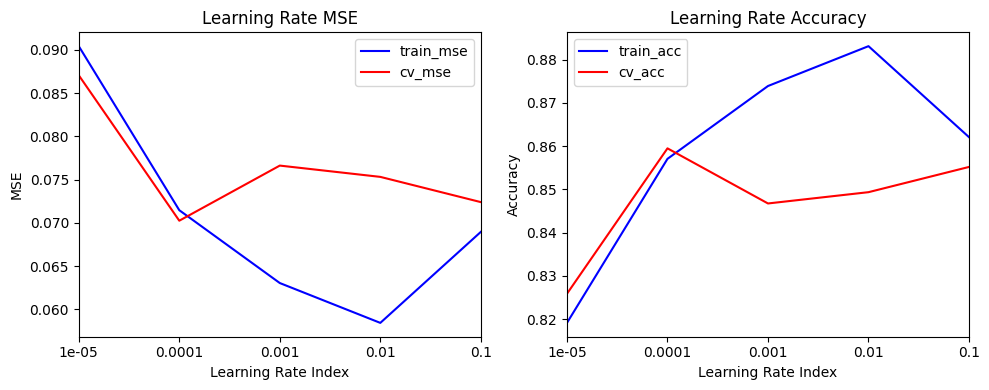

(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Learning Rate MSE'}, xlabel='Learning Rate Index', ylabel='MSE'>,
        <Axes: title={'center': 'Learning Rate Accuracy'}, xlabel='Learning Rate Index', ylabel='Accuracy'>],
       dtype=object))

In [11]:
plot_mse_acc(l_train_mse, l_cv_mse, l_train_acc, l_cv_acc, learning_list, name='Learning Rate')

In [12]:
print(f'The best loss/accuracy learning rate is {learning_list[optimal_learning_rate]} for this model')

The best loss/accuracy learning rate is 0.0001 for this model


### Regularization Parameter Tuning

In [13]:
regularization_list = [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
regularization_len = len(regularization_list)
r_train_mse, r_cv_mse = [], []
r_train_acc, r_cv_acc = [], []

for i in range(regularization_len):
  model, history = base_model(learning_rate=learning_list[optimal_learning_rate], batch_size=200, epochs=10, lambda_=regularization_list[i])
  r_train_mse, r_cv_mse, r_train_acc, r_cv_acc = append_mse_acc(model, r_train_mse, r_cv_mse, r_train_acc, r_cv_acc) 
optimal_regularization = np.argmin(r_cv_mse)


Epoch 1/10
98/98 [==============================] - 1s 3ms/step - loss: 0.4936 - accuracy: 0.7598
Epoch 2/10
98/98 [==============================] - 0s 3ms/step - loss: 0.3691 - accuracy: 0.8126
Epoch 3/10
98/98 [==============================] - 0s 3ms/step - loss: 0.3391 - accuracy: 0.8311
Epoch 4/10
98/98 [==============================] - 0s 2ms/step - loss: 0.3268 - accuracy: 0.8369
Epoch 5/10
98/98 [==============================] - 0s 2ms/step - loss: 0.3201 - accuracy: 0.8420
Epoch 6/10
98/98 [==============================] - 0s 2ms/step - loss: 0.3157 - accuracy: 0.8443
Epoch 7/10
98/98 [==============================] - 0s 2ms/step - loss: 0.3126 - accuracy: 0.8459
Epoch 8/10
98/98 [==============================] - 0s 2ms/step - loss: 0.3102 - accuracy: 0.8471
Epoch 9/10
98/98 [==============================] - 0s 2ms/step - loss: 0.3087 - accuracy: 0.8490
Epoch 10/10
204/204 [==============================] - 0s 1ms/step
Epoch 1/10
98/98 [==============================] -

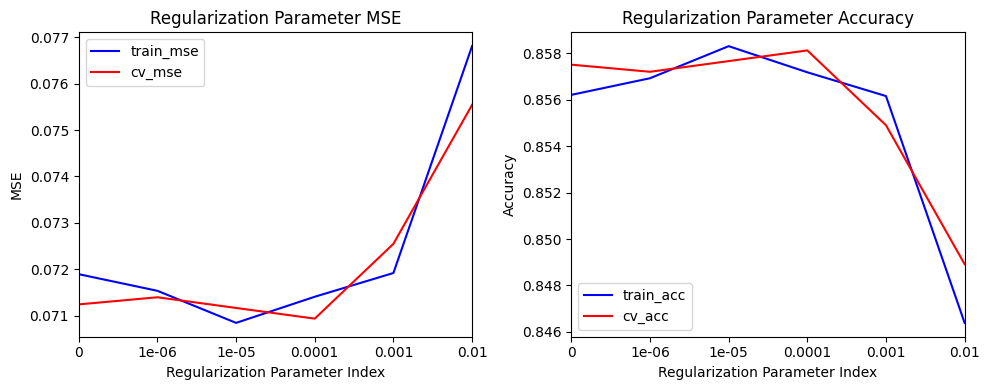

(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Regularization Parameter MSE'}, xlabel='Regularization Parameter Index', ylabel='MSE'>,
        <Axes: title={'center': 'Regularization Parameter Accuracy'}, xlabel='Regularization Parameter Index', ylabel='Accuracy'>],
       dtype=object))

In [14]:
plot_mse_acc(r_train_mse, r_cv_mse, r_train_acc, r_cv_acc, regularization_list, name='Regularization Parameter')

In [15]:
print(f'The best loss/accuracy Regularization Parameter is {regularization_list[optimal_regularization]:.1e} for this model')

The best loss/accuracy Regularization Parameter is 1.0e-04 for this model


### Tuning Conclusion

In [16]:
model, history = base_model(learning_list[optimal_learning_rate], 200, 10, regularization_list[optimal_regularization])

Epoch 1/10
98/98 [==============================] - 1s 3ms/step - loss: 0.5668 - accuracy: 0.7552
Epoch 2/10
98/98 [==============================] - 0s 3ms/step - loss: 0.4108 - accuracy: 0.7979
Epoch 3/10
98/98 [==============================] - 0s 2ms/step - loss: 0.3702 - accuracy: 0.8313
Epoch 4/10
98/98 [==============================] - 0s 2ms/step - loss: 0.3565 - accuracy: 0.8400
Epoch 5/10
98/98 [==============================] - 0s 3ms/step - loss: 0.3492 - accuracy: 0.8437
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 0.3445 - accuracy: 0.8466
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.3411 - accuracy: 0.8480
Epoch 8/10
98/98 [==============================] - 0s 4ms/step - loss: 0.3384 - accuracy: 0.8489
Epoch 9/10
98/98 [==============================] - 0s 3ms/step - loss: 0.3366 - accuracy: 0.8505
Epoch 10/10
98/98 [==============================] - 0s 3ms/step - loss: 0.3348 - accuracy: 0.8516


In [17]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test Accuracy: {test_acc}')
print(f'Test Loss: {test_loss}')

204/204 - 0s - loss: 0.3280 - accuracy: 0.8550 - 433ms/epoch - 2ms/step
Test Accuracy: 0.8550368547439575
Test Loss: 0.3280004560947418
